# __🗺️ Time Series Analysis Roadmap__
---

## __1.⚡Motivación__

<div style="width: 95%; text-align: justify; text-indent: 0px; margin-bottom: 20px;font-size: 19px;">
El objetivo de este proyecto, es generar un ambiente de autoaprendizaje sobre el manejo de series de tiempo en Python. Se busca, analizar, graficar, representar, corregir, imputar y preparar la data para realizar los primeros análisis de integridad de la serie de tiempo. Posteriormente, se implementarán evaluarán modelos de ML para determinar la mejor metodología para hacer pronósticos considerando la serie de tiempo generada y las complicaciones introducidas artificialmente. Finalmente, se busca generar una breve discusión del proceso completo que se genera sobre este notebook, buscando estructurar un hilo del pensamiento lógico-operativo-téorico de como abordar un proyecto relativo a modelos de forecasting.
 </div>
<div style="width: 95%; text-align: justify; text-indent: 0px; margin-bottom: 20px;font-size: 19px;">
El enfoque que se busca, no es solo una comprensión de este amplio tema desde el punto de vista de la codificación, sino que también se pretende generar un entendimiento de las definiciones matemáticas y probabilisticas de las series de tiempo, su modelado, técnicas y aplicaciones. Se hace incapié en el entendimiento analítico y estadístico-probabilistico del diagrama de secuencia, sus propiedades y supuestos necesarios para garantizar la estabilidad de la serie, junto con las correcciones necesarias para tener data correctamente formateada para trabajar. Los resultados, tablas, códigos y otros outputs, se pueden encontrar en el <a href="https://github.com/hector1994/time_series_analysis" style="color: #6166efff; font-weight: bold; text-decoration: none;">repositorio de GitHub</a> asociado a este proyecto. 
 </div>


## __2.📉Series de tiempo. Overview__

## __3.📚 Librerías y configuraciones generales__

In [1]:
#MAIN NECCESARY IMPORTS.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from   plotly.subplots import make_subplots

#SETTINGS SOME PARAMETERS FOR PLOTS.
sns.color_palette("viridis") 
sns.set_palette("viridis")
plt.rcParams['figure.dpi']  = 200  # Resolución en pantalla
plt.rcParams['savefig.dpi'] = 300 # Resolución al guardar archivos

#PYTHON VERSION
import sys
print(sys.version)

#SESSION INFO
import session_info
session_info.show()

3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]


## __4.🛠️Raw Data. Generación de serie de tiempo__

In [2]:
def generate_time_series_data(n_points=1000):
    np.random.seed(42)
    time  = np.arange(n_points)   
    dates = pd.date_range(end=pd.Timestamp.now().normalize(),periods=n_points,freq='D')
    
    # VALOR BASE + TENDENCIA + ESTACIONALIDAD
    y = 50 + (0.002 * time**1.6) + (7 * np.sin(2 * np.pi * time / 7)) + (12 * np.sin(2 * np.pi * time / 30.5))
    
    # RUIDO Y AUTOCORRELACIÓN
    ar = np.zeros(n_points)
    for t in range(1, n_points):
        ar[t] = 0.7 * ar[t-1] + np.random.normal(0, 1)
    
    noise = np.random.normal(0, 1 + 0.005 * time, n_points)
    y += ar + noise + np.where(time > 700, 30, 0) 
    y = np.maximum(y, 1.0) 
    
    ts = pd.DataFrame({'value': y}, index=dates)

    # OUTLIERS (1.5x)
    outlier_idx = np.random.choice(n_points, size=15, replace=False)
    ts.iloc[outlier_idx, 0] = ts.iloc[outlier_idx, 0] * 1.5 
    
    # NULOS AL 8%
    nan_idx = np.random.choice(n_points, size=int(n_points * 0.08), replace=False)
    ts.iloc[nan_idx, 0] = np.nan
    
    return ts 

# LLAMADA CORRECTA
ts = generate_time_series_data()

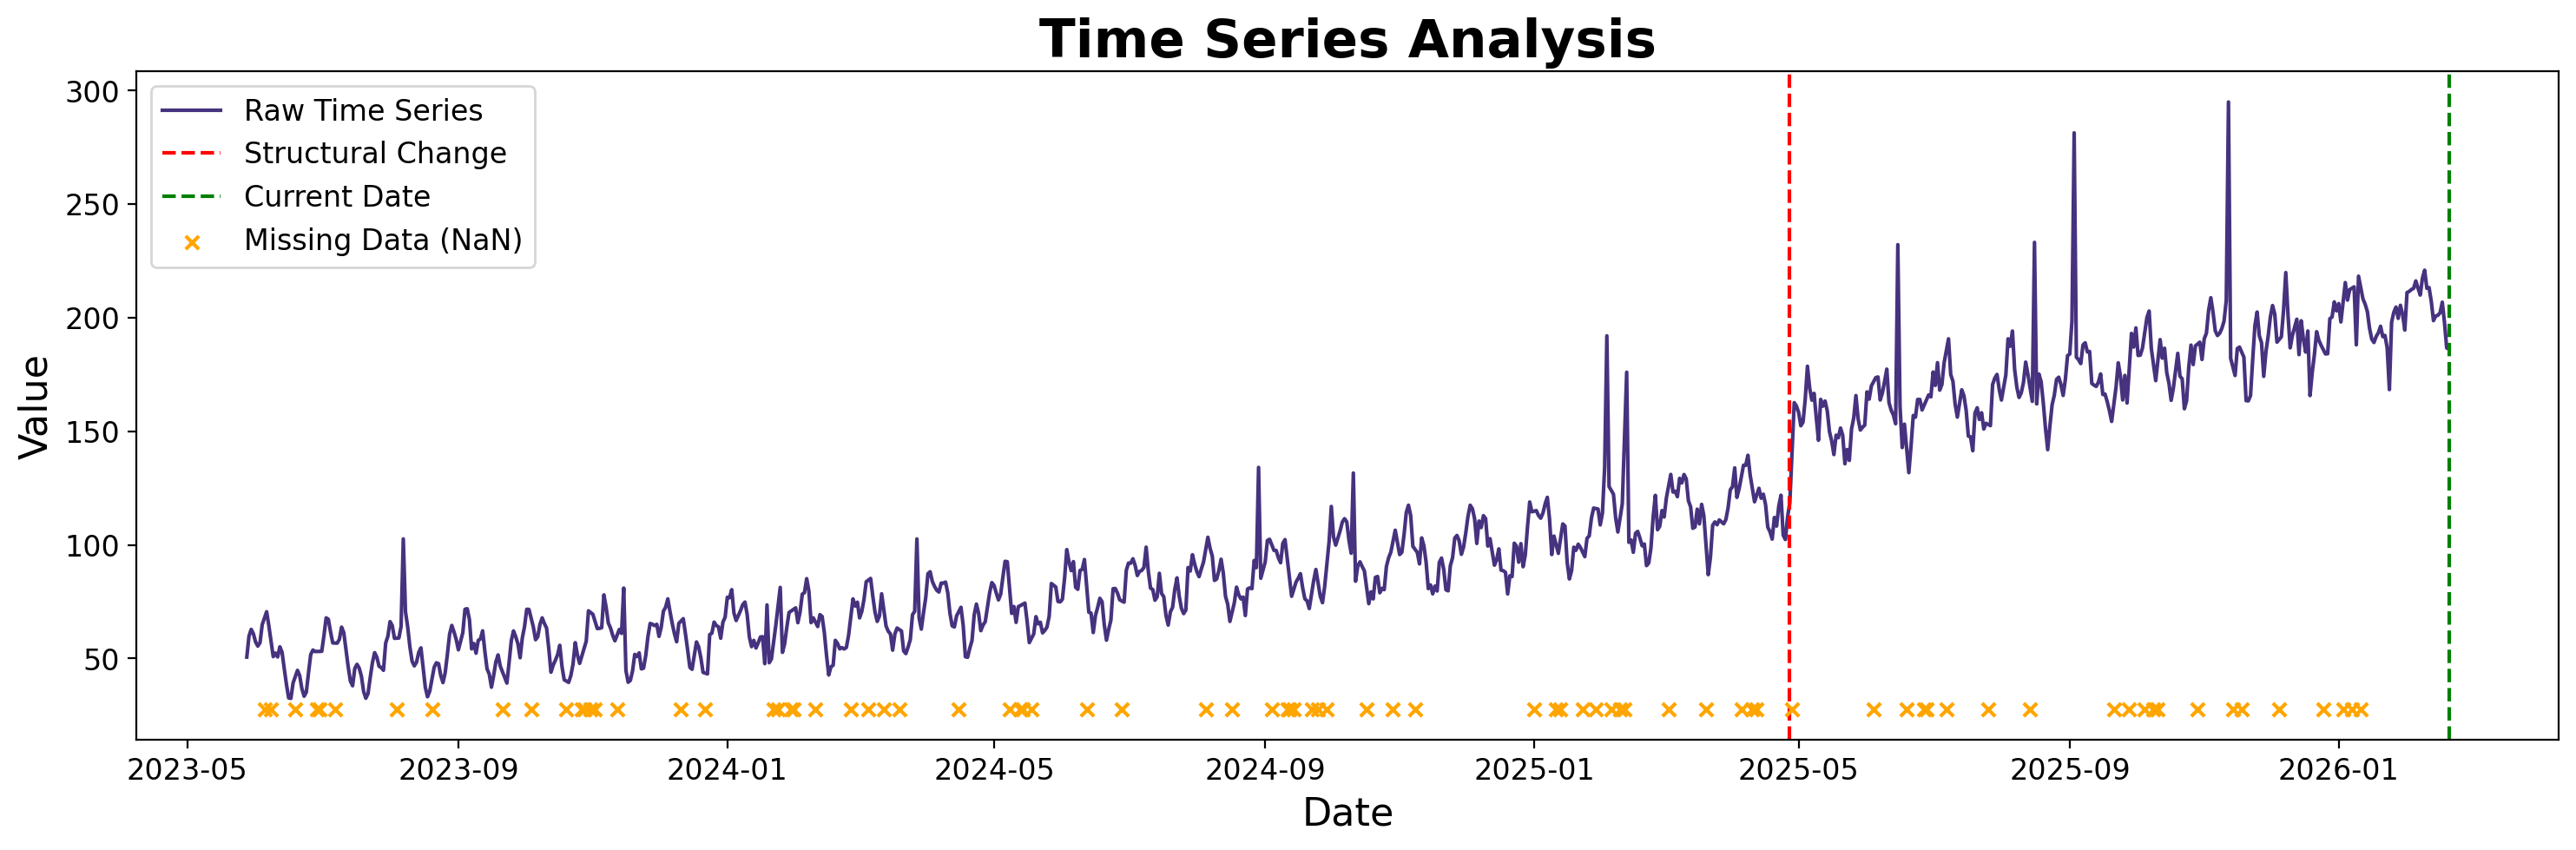

In [3]:
plt.figure(figsize=(18,5))
sns.lineplot(data = ts, x = ts.index, y = 'value', linewidth = 1.5, label='Raw Time Series') 
plt.xlabel('Date',fontsize=16)
plt.ylabel('Value',fontsize=16)
plt.title('Time Series Analysis',fontsize=22, fontweight = 'bold')
plt.axvline(ts.index[700], color='red', linestyle='--', label='Structural Change')
plt.axvline(ts.index[ts.shape[0]-1], color='green', linestyle='--', label='Current Date')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 

nulos = ts[ts['value'].isna()]
y_base = ts['value'].min() - 5
plt.scatter(nulos.index, [y_base] * len(nulos), color='orange', marker='x', s=30, label = 'Missing Data (NaN)', zorder=5)
plt.legend(fontsize=12)

plt.savefig('time_series_plot_v2.png')
plt.show()

In [4]:
df.describe()

NameError: name 'df' is not defined

In [ ]:
def plot_dynamic_series(df):
    # 1. Crear la figura
    fig = go.Figure()

    # 2. Agregar la Serie Principal (Raw Data)
    fig.add_trace(go.Scatter(
        x=df.index, 
        y=df['value'],
        mode='lines',
        name='Raw Time Series',
        line=dict(color='#2E86C1', width=1.0),
        connectgaps=False # Importante: deja el hueco visual donde hay NaN
    ))

    # 3. Agregar los Nulos (Cruces en la base)
    nulos = df[df['value'].isna()]
    # Colocamos las cruces un poco abajo del valor mínimo para que no estorben
    y_base = [df['value'].min() - 10] * len(nulos)
    
    fig.add_trace(go.Scatter(
        x=nulos.index,
        y=y_base,
        mode='markers',
        name='Missing Data (NaN)',
        marker=dict(color='orange', symbol='x', size=8),
        hoverinfo='x' # Solo muestra la fecha al pasar el mouse
    ))

    # 4. Línea de Quiebre Estructural
    fig.add_vline(
        x=df.index[700].timestamp() * 1000, 
        line_dash="dash", 
        line_color="red",
        annotation_text="Structural Break", 
        annotation_position="top left"
    )

    # 5. Configuración de Layout Pro
    fig.update_layout(
        title='<b>Interactive Time Series Analysis</b>',
        xaxis_title='Date',
        yaxis_title='Value',
        hovermode='x unified', # Muestra todos los valores en esa fecha al unísono
        template='plotly_white',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    # 6. Activar Range Selector (Zoom rápido)
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig.write_html("analisis_dinamico.html")
    fig.show()

plot_dynamic_series(ts)

In [ ]:
# 1. Creamos una copia y extraemos la "Verdad Absoluta" (Ground Truth)
# Tomamos un tramo que sepamos que TIENE datos reales
indices_test = df.index[400:430]
ground_truth = df.loc[indices_test, 'value'].copy()

# 2. Creamos un DataFrame de prueba donde BORRAMOS esos datos
df_eval = df.copy()
df_eval.loc[indices_test, 'value'] = np.nan  # Aquí creamos el hueco artificial

# 3. Aplicamos las imputaciones sobre el hueco artificial
pred_linear = df_eval['value'].interpolate(method='linear').loc[indices_test]
pred_spline = df_eval['value'].interpolate(method='cubic').loc[indices_test]

# 4. Ahora sí, calculamos métricas reales
def get_metrics(real, pred):
    mask = ~real.isna() # Por si acaso hubiera nulos originales en ese tramo
    r, p = real[mask], pred[mask]
    return {
        'RMSE': np.sqrt(mean_squared_error(r, p)),
        'MAE': mean_absolute_error(r, p),
        'MAPE %': mean_absolute_percentage_error(r, p) * 100,
        'sMAPE %': 100 * np.mean(2 * np.abs(p - r) / (np.abs(r) + np.abs(p)))
    }

metrics_comparison = pd.DataFrame({
    'Linear': get_metrics(ground_truth, pred_linear),
    'Spline Cúbico': get_metrics(ground_truth, pred_spline)
}).T

print("--- Evaluación Real de Imputación ---")
print(metrics_comparison.round(4))

--- Evaluación Real de Imputación ---
                  RMSE      MAE   MAPE %  sMAPE %
Linear         12.1508   9.5096  12.6529  11.4510
Spline Cúbico  65.6587  59.7303  74.9348  51.6705
